<a href="https://colab.research.google.com/github/Vinicius-S-Grilo/Portfolio/blob/main/MVP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **A - Machine Learning**

**Definição do problema**

O dataset escolhido aborda um problema de classificação. Trata-se de uma instituição de ensino superior que deseja avaliar se um aluno irá concluir ou desistir do curso baseado em uma série de atributos como curso, performace academica, fatores socio-econômicos entre outros.

mais informações a respeito do dataset pode ser encontrada em https://archive.ics.uci.edu/dataset/697/predict+students+dropout+and+academic+success

Há três categorias possíveis: *dropout*, *enrolled* e *graduate*

O dataset já foi previamente preprocessado para remoção de missing values e outliers.

In [ ]:
#importando as bibliotecas a serem utilizadas
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import requests
from bs4 import BeautifulSoup
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import RFE
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

**Preparação dos dados**

Como os dados já vieram pre processados, não há necessidade de utilizar técnicas de pre processamento para tratamento de missing values ou remoção de outliers.

Nesta etapa, será feito o carregamento do dataset, separação entre treino/teste, parametrização pra validação cruzada, criação e comparação dos modelos.

In [ ]:
#Carregando o dataset
dataset = pd.read_csv(r"/content/data.csv", sep=';')

In [ ]:
#Tratando os dados para treinamento do modelo
np.random.seed(10)

#separação dos atributos e da categoria
X = np.array(dataset.iloc[:,:-1].copy())
y = np.array(dataset.iloc[:,-1].copy())

#separação teste/treino
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=10)

#Parâmetros para validação cruzada
n_part = 10
kfold = KFold(n_splits=n_part,shuffle=True, random_state=10)

#Criação e preparação dos modelos e seus resultados
models = []
results = []
names = []

models.append(("KNN",KNeighborsClassifier()))
models.append(('LR', LogisticRegression(max_iter=200)))
models.append(("CART",DecisionTreeClassifier()))
models.append(("NB",GaussianNB()))
models.append(("SVC",SVC()))

for name,model in models:
    cv_results = cross_val_score(model,X_train,y_train,cv=kfold,scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    msg = f"{name}: {cv_results.mean()} ({cv_results.std()})"
    print(msg)


KNN: 0.5936788783790271 (0.027958817701309913)
LR: 0.6953793953361822 (0.025023645819575304)
CART: 0.6801323602375122 (0.01516551542951282)
NB: 0.6869056193082697 (0.029678089117343605)
SVC: 0.5035194699188554 (0.02250900968881935)


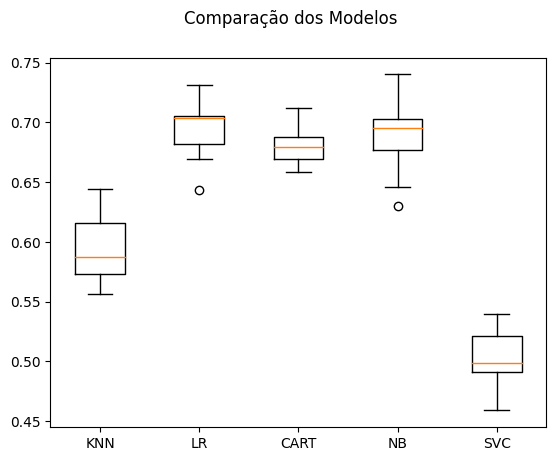

In [ ]:
#Boxplot para comparar a precisão dos modelos
fig = plt.figure()
fig.suptitle('Comparação dos Modelos')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [ ]:
#Testando a precisão dos modelos com o dado teste
best_models_list = ["NB","CART","LR"]

for i in models:
  if i[0] in best_models_list:
    model = i[1]
    model.fit(X_train,y_train)
    predictions = model.predict(X_test)
    print(f"Precisão de {i[0]}: {accuracy_score(y_test,predictions):.2%} ")


Precisão de LR: 66.89% 
Precisão de CART: 68.14% 
Precisão de NB: 64.29% 


Com base no plot acima, é possível perceber que o modelo com maior precisão é o de Regressão Logística (LR), seguido do Naive Bayes e da Árvore de Decisão. Como não há diferença estatística significativa entre os três modelos, vou seguir com eles para testar uma abordagem de feature selection e avaliar se a precisão dos modelos melhora.

In [ ]:
#Testando feature selection pra otimizar modelo
#números de features a serem escolhidos
n = 15

print("Atributos Originais:\n", dataset.columns[0:36])
print("\n\n##Iniciando os testes com feature selection##\n\n")

#teste ANOVA de Seleção Univariada
best_var = SelectKBest(score_func=f_classif, k=n)

fit = best_var.fit(X,y)

features=fit.transform(X)

#Print dos resultados
print("Resultados do ANOVA - seleção univariada\n")
print(f"Atributos originais: {X.shape[1]}")
print(f"Atributos reduzidos: {features.shape[1]}")

print("Scores dos Atributos Originais:", fit.scores_)
print("\nAtributos Selecionados:", best_var.get_feature_names_out(input_features=dataset.columns[0:36]))

red_features_f = best_var.get_feature_names_out(input_features=dataset.columns[0:36])


# Eliminação Recursiva de Atributos

# Criação do modelo
modelo = LogisticRegression(max_iter=200)

# Eliminação Recursiva de Atributos
rfe = RFE(modelo, n_features_to_select=n)
fit = rfe.fit(X, y)

# Print dos resultados

print("\nResultados da Eliminação recursiva de atributos\n")


# Exibe os atributos selecionados (marcados como True em "Atributos Selecionados"
# e com valor 1 em "Ranking dos Atributos")
print("\nAtributos Selecionados: %s" % fit.support_)
print("\nRanking de atributos: %s" % fit.ranking_)
print("\nQtd de melhores Atributos: %d" % fit.n_features_)
print("\nNomes dos Atributos Selecionados: %s" % fit.get_feature_names_out(input_features=dataset.columns[0:36]))
red_features_RFE = fit.get_feature_names_out(input_features=dataset.columns[0:36])

# Importância de Atributos com ExtraTrees
# Criação do modelo para seleção de atributos
modelo = ExtraTreesClassifier(n_estimators=100)
modelo.fit(X,y)


# Exibe a pontuação de importância para cada atributo (quanto maior a pontuação, mais importante é o atributo).
print("\nResultados da Importância de atributos com ExtraTrees\n")
print(modelo.feature_importances_)
ipt=modelo.feature_importances_
red_features_ExT = dataset.columns[0:36][ipt.argsort()[-n:]]
print(f"\nAtributos selecionados {red_features_ExT}\n")









Atributos Originais:
 Index(['Marital status', 'Application mode', 'Application order', 'Course',
       'Daytime/evening attendance\t', 'Previous qualification',
       'Previous qualification (grade)', 'Nacionality',
       'Mother's qualification', 'Father's qualification',
       'Mother's occupation', 'Father's occupation', 'Admission grade',
       'Displaced', 'Educational special needs', 'Debtor',
       'Tuition fees up to date', 'Gender', 'Scholarship holder',
       'Age at enrollment', 'International',
       'Curricular units 1st sem (credited)',
       'Curricular units 1st sem (enrolled)',
       'Curricular units 1st sem (evaluations)',
       'Curricular units 1st sem (approved)',
       'Curricular units 1st sem (grade)',
       'Curricular units 1st sem (without evaluations)',
       'Curricular units 2nd sem (credited)',
       'Curricular units 2nd sem (enrolled)',
       'Curricular units 2nd sem (evaluations)',
       'Curricular units 2nd sem (approved)',
      

In [ ]:
#Mostrando os top 15 atributos selcionados de acordo com as técnicas de feature selection

print(f"ANOVA - {red_features_f}\n")
print(f"RFE - {red_features_RFE}\n")
print(f"ExtraTrees - {red_features_ExT}")

ANOVA - ['Application mode' 'Admission grade' 'Debtor' 'Tuition fees up to date'
 'Gender' 'Scholarship holder' 'Age at enrollment'
 'Curricular units 1st sem (enrolled)'
 'Curricular units 1st sem (evaluations)'
 'Curricular units 1st sem (approved)' 'Curricular units 1st sem (grade)'
 'Curricular units 2nd sem (enrolled)'
 'Curricular units 2nd sem (evaluations)'
 'Curricular units 2nd sem (approved)' 'Curricular units 2nd sem (grade)']

RFE - ['Marital status' 'Displaced' 'Debtor' 'Tuition fees up to date' 'Gender'
 'Scholarship holder' 'Curricular units 1st sem (credited)'
 'Curricular units 1st sem (enrolled)'
 'Curricular units 1st sem (approved)'
 'Curricular units 1st sem (without evaluations)'
 'Curricular units 2nd sem (credited)'
 'Curricular units 2nd sem (enrolled)'
 'Curricular units 2nd sem (evaluations)'
 'Curricular units 2nd sem (approved)'
 'Curricular units 2nd sem (without evaluations)']

ExtraTrees - Index(['Mother's occupation', 'Father's occupation', 'Applicatio

ANOVA training
LR-ANOVA: 0.7651886173396714 (0.014581238931198266)
RFE training
LR-RFE: 0.7674437028856773 (0.01766379139362151)
ExT training
LR-ExT: 0.7015972855748147 (0.025887845917512583)
ANOVA training
CART-ANOVA: 0.6747707303020117 (0.022876279745073468)
RFE training
CART-RFE: 0.7069645172132328 (0.029204952134647258)
ExT training
CART-ExT: 0.6789984155183176 (0.02623187833464461)
ANOVA training
NB-ANOVA: 0.7216641859125174 (0.021644211414913423)
RFE training
NB-RFE: 0.6897384804980715 (0.02215459519516164)
ExT training
NB-ExT: 0.7052808053648308 (0.019001207582004985)


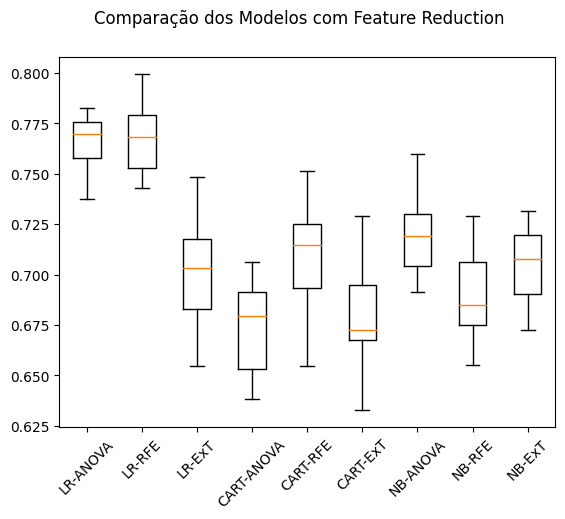

In [ ]:
#Retreinando o modelo com inputs reduzidos de acordo com cada técnica

X_anova = np.array(dataset.loc[:,red_features_f].copy())
X_rfe = np.array(dataset.loc[:,red_features_RFE].copy())
X_ExT = np.array(dataset.loc[:,red_features_ExT].copy())

feat_red_tecs = [("ANOVA",X_anova),
                ("RFE", X_rfe),
                ("ExT",X_ExT)]

new_results = []
names = []

for name,model in models:
  for i in feat_red_tecs:
    if name in best_models_list:
      print(f"{i[0]} training")
      #new splits
      X_train, X_test, y_train, y_test = train_test_split(i[1],y, test_size=0.2, random_state=10)
      cv_results = cross_val_score(model,X_train,y_train,cv=kfold,scoring='accuracy')
      new_results.append(cv_results)
      names.append(name+"-"+i[0])

      msg = f"{name}-{i[0]}: {cv_results.mean()} ({cv_results.std()})"
      print(msg)
fig = plt.figure()
fig.suptitle(f'Comparação dos Modelos com Feature Reduction')
ax = fig.add_subplot(111)
plt.boxplot(new_results)
ax.set_xticklabels(names, rotation = 45)
plt.show()


In [ ]:
#Testando a precisão dos modelos retreinados
predict_results = {}

for name,model in models:
  for i in feat_red_tecs:
    if name in best_models_list:
      model = model
      X_train, X_test, y_train, y_test = train_test_split(i[1],y, test_size=0.2, random_state=10)
      model.fit(X_train,y_train)
      predictions = model.predict(X_test)
      print(f"Precisão de {name}-{i[0]}: {accuracy_score(y_test,predictions):.2%} ")
      predict_results[f"{name}-{i[0]}"]=accuracy_score(y_test,predictions)


Precisão de LR-ANOVA: 74.35% 
Precisão de LR-RFE: 72.66% 
Precisão de LR-ExT: 66.89% 
Precisão de CART-ANOVA: 66.78% 
Precisão de CART-RFE: 72.09% 
Precisão de CART-ExT: 64.86% 
Precisão de NB-ANOVA: 69.15% 
Precisão de NB-RFE: 65.88% 
Precisão de NB-ExT: 67.57% 


In [ ]:
#Relembrando as precisões originais
for name,model in models:
  if name in best_models_list:
    model = model
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=10)
    model.fit(X_train,y_train)
    predictions = model.predict(X_test)
    print(f"Precisão de {name}: {accuracy_score(y_test,predictions):.2%} ")
    predict_results[f"{name}"]=accuracy_score(y_test,predictions)

Precisão de LR: 66.89% 
Precisão de CART: 68.47% 
Precisão de NB: 64.29% 


In [ ]:
for i in predict_results.keys():
  if "LR-" in i:
    print(f"{i} - {predict_results[i]/predict_results['LR']-1:.2%}")
  elif "CART-" in i:
    print(f"{i} - {predict_results[i]/predict_results['LR']-1:.2%}")
  elif "NB-" in i:
    print(f"{i} - {predict_results[i]/predict_results['NB']-1:.2%}")

LR-ANOVA - 11.15%
LR-RFE - 8.61%
LR-ExT - 0.00%
CART-ANOVA - -0.17%
CART-RFE - 7.77%
CART-ExT - -3.04%
NB-ANOVA - 7.56%
NB-RFE - 2.46%
NB-ExT - 5.10%


Por essa análise, foi possível observar que reduzindo o número de atributos foi possível aumentar a precisão da maioria dos modelos quando comparado com o resultado utilizando todos os atributos. Porém, pra alguns modelos como no CART, houve uma piora quando aplicada as técnicas de ANOVA e da Extra Tree.


Ainda buscando otimizar esses três modelos, é possível testar diferentes hiperparâmetros com o GridSearchCV.


Para isso, verifica-se quais os parâmetros existentes de cada modelo, para então propor possíveis alterações e avaliar o impacto delas na precisão do mesmo.

In [ ]:
LogisticRegression().get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [ ]:
GaussianNB().get_params()

{'priors': None, 'var_smoothing': 1e-09}

In [ ]:
DecisionTreeClassifier().get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [ ]:
#Definindo os parâmetros a serem testados nos modelos com o GridSearchCV
CART_param_grid = {'criterion':['gini','entropy'],
                 'max_features': [6,10,15,18],
                 'splitter':['best','random'],
                 'max_depth':[2,10,50,100]
}

LR_param_grid = {'C': [1.0],
                'class_weight': [None,'balanced'],
                'max_iter': [200,300,400],
                'n_jobs': [-1],
                'penalty': ['l2'],
                'solver': ['lbfgs','newton-cg','liblinear']
}

NB_param_grid = {'var_smoothing': [1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10, 1e-11, 1e-12]}


In [ ]:
top_3_models = list(zip(best_models_list,(GaussianNB(),DecisionTreeClassifier(),LogisticRegression()),(NB_param_grid,CART_param_grid,LR_param_grid)))

In [ ]:
#Buscando pelos melhores parâmetros

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=10) #Por razões práticas, redefi o train/test split de novo nesta célula

for name,model,params in top_3_models:
  print(f"Testing {name} parameters")
  grid = GridSearchCV(estimator=model,param_grid=params,scoring='accuracy',cv=kfold,n_jobs=-1)
  grid.fit(X_train,y_train)
  print(f"{name} - Melhor: {grid.best_score_} usando os seguintes parametros {grid.best_params_}")
  predictions = grid.predict(X_test)
  print(f"Precisão de {name}: {accuracy_score(y_test,predictions):.2%} ")

Testing NB parameters
NB - Melhor: 0.6973567964661257 usando os seguintes parametros {'var_smoothing': 1e-08}
Precisão de NB: 66.89% 
Testing CART parameters
CART - Melhor: 0.7284486483891104 usando os seguintes parametros {'criterion': 'gini', 'max_depth': 10, 'max_features': 18, 'splitter': 'best'}
Precisão de CART: 69.94% 
Testing LR parameters
LR - Melhor: 0.7713977049022903 usando os seguintes parametros {'C': 1.0, 'class_weight': None, 'max_iter': 200, 'n_jobs': -1, 'penalty': 'l2', 'solver': 'liblinear'}
Precisão de LR: 73.45% 


In [ ]:
#Testando o GridSearch com o feature selection
for i in feat_red_tecs:
  print(f"\nCombinando input reduizo via {i[0]}\n")
  X_train, X_test, y_train, y_test = train_test_split(i[1],y, test_size=0.2, random_state=10)
  for name,model,params in top_3_models:
    print(f"Testing {name} parameters")
    grid = GridSearchCV(estimator=model,param_grid=params,scoring='accuracy',cv=kfold,n_jobs=-1)
    grid.fit(X_train,y_train)
    print(f"{name} - Melhor: {grid.best_score_} usando os seguintes parametros {grid.best_params_}")
    predictions = grid.predict(X_test)
    print(f"Precisão de {name}: {accuracy_score(y_test,predictions):.2%} ")


Combinando input reduizo via ANOVA

Testing NB parameters
NB - Melhor: 0.7242081592804213 usando os seguintes parametros {'var_smoothing': 1e-05}
Precisão de NB: 69.38% 
Testing CART parameters
CART - Melhor: 0.7397560858500983 usando os seguintes parametros {'criterion': 'gini', 'max_depth': 10, 'max_features': 18, 'splitter': 'random'}
Precisão de CART: 72.54% 
Testing LR parameters
LR - Melhor: 0.7702725628591092 usando os seguintes parametros {'C': 1.0, 'class_weight': None, 'max_iter': 300, 'n_jobs': -1, 'penalty': 'l2', 'solver': 'lbfgs'}
Precisão de LR: 73.45% 

Combinando input reduizo via RFE

Testing NB parameters
NB - Melhor: 0.6897384804980715 usando os seguintes parametros {'var_smoothing': 1e-07}
Precisão de NB: 65.88% 
Testing CART parameters
CART - Melhor: 0.7437076871368896 usando os seguintes parametros {'criterion': 'gini', 'max_depth': 10, 'max_features': 6, 'splitter': 'best'}
Precisão de CART: 72.66% 
Testing LR parameters
LR - Melhor: 0.7674437028856773 usando o

Utilizar a predição logo no grid é possível por conta do parâmetro default refit=True, que já otimiza o estimator com os melhores parâmetros identificados.

**Resultados e discussão**

Após a construção dos modelos, verificou-se que os três modelos com maior precisão era a Árvore de Classificação (CART), Regressão logística (LR) e o Naive Bayes (NB) com as seguintes precisões:

*   Precisão de LR: 66.89%
*   Precisão de CART: 68.47%
*   Precisão de NB: 64.29%

Na tentativa de otimizar os modelos, foram utilizadas algumas técnicas de *feature selection*. Com isso, foi observado que a precisão dos modelos na maioria dos casos aumentou, com exceção do CART com ANOVA e ExtraTrees:



*  Precisão de LR-ANOVA: 74.35%
*  Precisão de LR-RFE: 72.66%
*  Precisão de LR-ExT: 68.14%
*  Precisão de CART-ANOVA: 67.46%
*  Precisão de CART-RFE: 71.30%
*  Precisão de CART-ExT: 66.33%
*  Precisão de NB-ANOVA: 69.15%
*  Precisão de NB-RFE: 65.88%
*  Precisão de NB-ExT: 69.15%

Ainda explorando a ideia de otimizar o modelos visando aumentar sua precisão, foi feito um GridSeachCV na tentativa de otimizar os hiperparâmetros e encontrar aqueles que pudesse melhorar o desempenho dos modelos. Com isso, chegamos aos seguintes resultados pra cada modelo:

*  Testing NB parameters

  NB - Melhor: 0.6973567964661257 usando os seguintes parametros {'var_smoothing': 1e-08}
  Precisão de NB: 66.89%

*  Testing CART parameters

  CART - Melhor: 0.7301419631567997 usando os seguintes parametros {'criterion': 'gini', 'max_depth': 10, 'max_features': 15, 'splitter': 'random'}
  Precisão de CART: 69.83%


* Testing LR parameters

  LR - Melhor: 0.7713977049022903 usando os seguintes parametros {'C': 1.0, 'class_weight': None, 'max_iter': 200, 'n_jobs': -1, 'penalty': 'l2', 'solver': 'liblinear'}
  Precisão de LR: 73.45%

Com esses resultados, foi possível observar um aumento na precisão de todos os modelos NB de 64.29% pra 66.89%, LR de 66.89% pra 73.45% e CART de 68.47% pra 69.83%, sendo o maior ganho no modelo de Regressão logística.

Por fim, foi tentada uma combinação dos modelos treinados com os inputs aos quais foram aplicados *feature selection*.

Seguem os resultados:

* Combinando input reduizo via ANOVA

 *  Testing NB parameters

    NB - Melhor: 0.7242081592804213 usando os seguintes parametros {'var_smoothing': 1e-05}
    Precisão de NB: 69.38%

  *  Testing CART parameters

    CART - Melhor: 0.7400353707527089 usando os seguintes parametros {'criterion': 'gini', 'max_depth': 10, 'max_features': 18, 'splitter': 'random'}
    Precisão de CART: 70.17%

  *  Testing LR parameters

    LR - Melhor: 0.7702725628591092 usando os seguintes parametros {'C': 1.0, 'class_weight': None, 'max_iter': 300, 'n_jobs': -1, 'penalty': 'l2', 'solver': 'lbfgs'}
    Precisão de LR: 73.45%

*  Combinando input reduizo via RFE

  *  Testing NB parameters
    NB - Melhor: 0.6897384804980715 usando os seguintes parametros {'var_smoothing': 1e-07}
    Precisão de NB: 65.88%

  *  Testing CART parameters
    CART - Melhor: 0.7434300027208272 usando os seguintes parametros {'criterion': 'entropy', 'max_depth': 10, 'max_features': 15, 'splitter': 'random'}
    Precisão de CART: 71.86%

  *  Testing LR parameters

    LR - Melhor: 0.7674437028856773 usando os seguintes parametros {'C': 1.0, 'class_weight': None, 'max_iter': 200, 'n_jobs': -1, 'penalty': 'l2', 'solver': 'lbfgs'}
    Precisão de LR: 72.66%

*  Combinando input reduizo via ExT

 *  Testing NB parameters

    NB - Melhor: 0.7222355596101214 usando os seguintes parametros {'var_smoothing': 1e-08}
    Precisão de NB: 70.28%

  *  Testing CART parameters
  
    CART - Melhor: 0.7405979417742994 usando os seguintes parametros {'criterion': 'entropy', 'max_depth': 10, 'max_features': 18, 'splitter': 'random'}
    Precisão de CART: 69.04%

  *  Testing LR parameters
    LR - Melhor: 0.7677285894912054 usando os seguintes parametros {'C': 1.0, 'class_weight': None, 'max_iter': 200, 'n_jobs': -1, 'penalty': 'l2', 'solver': 'newton-cg'}
    Precisão de LR: 74.01%





Para facilitar a visualização e comparação das precisões, segue abaixo uma tabela concatenando todas as informações:

| Modelo | Precisão (%) | Otimização
|--------|----------|-----------
| LR | 66.89 | -
| **LR**| **74.35** | **Feature selection - Anova**
| LR | 72.66 | Feature selection - RFE
| LR | 68.14 | Feature selection - ExT  
| LR | 73.45 | GridSearchCV
| LR | 73.45 | GridSearchCV + Anova
| LR | 72.66 | GridSearchCV + RFE
| LR | 74.01 | GridSearchCV + ExT
| NB | 64.29 | -
| NB | 69.15 | Feature selection - Anova
| NB | 65.88| Feature selection - RFE
| NB | 69.15 | Feature selection - ExT  
| NB | 66.89 | GridSearchCV
| NB | 69.38  | GridSearchCV + Anova
| NB | 65.88 | GridSearchCV + RFE
| **NB** | **70.28** | **GridSearchCV + ExT**
| CART | 68.47 | -
| CART | 67.46 | Feature selection - Anova
| CART | 71.30 | Feature selection - RFE
| CART | 66.33 | Feature selection - ExT  
| CART | 69.83 | GridSearchCV
| CART | 70.17 | GridSearchCV + Anova
| CART | 71.86 | GridSearchCV + RFE
| **CART** | **74.01**  | **GridSearchCV + ExT**

Destacados em negrito são os melhores resultados dos modelos.

Com isso é possível concluir que um fine tuning dos hiperparâmetros associado a técnicas de feature selection provocaram os melhores resultados para NB e CART, ao passo que para LR apenas um feature selection já foi o suficiente pra gerar a melhor precisão.

Também é importante ressaltar que diferentes inputs dos features selection geraram diferentes combinações de hiperparâmetros.



Como estratégia parar tentar otimizar ainda mais os modelos, poderíamos tentar criar Pipelines e trabalhar com dados padronizados e normalizados. E por fim compará-los com o resultado obtido atravez do dataset original.

No entanto acredito que para o dataset escolhido essa técnica não seria adequada, uma vez que a maioria dos atributos apesar de apresentarem valores inteiros, na verdade são variáveis categóricas, onde cada número representa uma categoria.

Por isso Pipelines não foram utilizados no projeto acima.

# **B - Deep learning**

**Definição do problema**

O dataset escolhido é de visão computacional e aborda um problema de classificação. É composto por 5 tipos diferentes de arroz, onde o objetivo da modelagem é conseguir construir um modelo pra classificar corretamente cada tipo de arroz.

O modelo escolhido foi uma CNN.

Mais informações a respeito do dataset pode ser encontrada em https://www.kaggle.com/datasets/muratkokludataset/rice-image-dataset

Há cinco categorias possíveis: *Arborio*, *Basmati*, *Ipsala*, *Jasmine*, *Karacadag*

O dataset compactado esta dividido em cinco pastas, cada uma nomeada de uma categoria, onde cada categoria possui 15000 imagens, totalizando 75000 imagens no dataset completo.

Por fins de poder e tempo computacional trabalhei apenas com 1/3 do dataset, ou seja, 5000 imagens de cada categoria para treinar o modelo.



In [ ]:
#Importando as bibliotecas a serem usadas nessa parte do projeto
import keras.models
import pandas as pd
import numpy as np
from tensorflow import keras
from IPython.display import Image, display
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.utils import load_img,img_to_array
# from keras.layers import Dense,Activation, Flatten, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
# from keras.layers import Conv2D, MaxPooling2D
# from keras import regularizers, optimizers
from keras import layers
from keras import models
import os
import shutil
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import sklearn.metrics as skm
import itertools
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import zipfile

#Definindo a função para plotar a matriz de confusão
def plot_confusion_matrix(cm,classes,normalize=False,
                          title='Confusion Matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
        print("Matriz de confusão normalizada")
    else:
        print('Matriz de confusão sem noramlização')

    plt.imshow(cm,interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks,classes, rotation=45)
    plt.yticks(tick_marks,classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max()/2.
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,format(cm[i,j],fmt),
                horizontalalignment="center",
                color="white" if cm[i,j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('Classe real')
    plt.xlabel('Classe predita')


**Preparação do dataset**

As imagens do dataset não vieram separadas em conjunto de treino, teste e validação. A seguir, o dataset será extraído, importado, reduzido a 1/3 do total e separado em conjunto de treino e teste.

Também será usado um data augmentation no conjunto de treino para otimizar o treinamento do modelo.

In [ ]:
zip_file =  r"C:\Users\vinis\Desktop\Pos_PUC_RJ\MVP\DL\Arroz\archive.zip"
working_dir = r"C:\Users\vinis\Desktop\Pos_PUC_RJ\MVP\DL\Arroz\Work"

os.makedirs(working_dir, exist_ok=True)

with zipfile.ZipFile(zip_file,'r') as z:
  z.extractall(working_dir)

folders = []
for i in os.listdir(working_dir+r'\Rice_Image_Dataset'):
    if len(i.split(sep='.'))>1:
        continue
    else:
        folders.append(os.path.join((working_dir+r'\Rice_Image_Dataset'),i))

os.chdir(working_dir+r'\Rice_Image_Dataset')

os.mkdir('All_images')

all_images = (working_dir+r'\Rice_Image_Dataset'+r'\All_images')

np.random.seed(10)

n_samples = 5000

for i in folders:
    t = np.random.choice(a=os.listdir(i), size=n_samples,replace=False)
    for pic in t:
        shutil.copy(os.path.join(i,pic),all_images)

labels, heights, widths, channels, filesize = [],[],[],[],[]

images_list = []
images_path_list = []

for img in os.listdir(all_images):
    labels.append(img.split(sep=' ')[0].capitalize())
    images_path_list.append(os.path.join(all_images,img))
    img_shape = mpimg.imread(os.path.join(all_images,img))
    heights.append(img_shape[0])
    widths.append(img_shape[1])
    channels.append(img_shape[2])
    filesize.append(os.path.getsize(os.path.join(all_images,img)))

data ={'images':os.listdir(all_images),
       'class':labels,
       'height':heights,
       'width':widths,
       'channels':channels,
       'size':filesize
       }

df= pd.DataFrame(data)

df['class'].value_counts()

#criando uma lista com as classes do problema
classes = df['class'].unique()

#variável pra armazenar o número de classes do problema
n_class = len(df['class'].unique())





In [ ]:
#Verificando que o dataset é de fato balanceado
df['class'].value_counts().plot.bar(title='Classes de arroz')

In [ ]:
#Vendo algumas imagens do dataset
for n in range(6):
    sample = np.random.choice(images_path_list)
    sp = plt.subplot(2,3,n+1)
    sp.axis('Off')
    img = mpimg.imread(sample)
    plt.imshow(img)
    plt.title(sample.split(sep='\\')[-1])

In [ ]:
#Separação entre treino e teste
np.random.seed(10)

train,test = train_test_split(df[['images','class']],test_size=0.3, random_state=10,shuffle=True)

#Tratamento de imagens, data augmentation, com o ImageDataGenerator
train_datagen=ImageDataGenerator(validation_split=0.2,
                                 rescale=1.0/255,
                                 rotation_range=30,
                                 shear_range=0.15,
                                 zoom_range=0.25,
                                 horizontal_flip=True,
                                 fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1.0/255)

train_aug = train_datagen.flow_from_dataframe(
            train, all_images,
            target_size=(250,250),
            batch_size=50,
            class_mode='categorical',
            x_col='images',
            y_col='class',
            subset='training')

test_aug = test_datagen.flow_from_dataframe(
            test, all_images,
            target_size=(250,250),
            batch_size=50,
            class_mode='categorical',
            x_col='images',
            y_col='class')

val_aug = train_datagen.flow_from_dataframe(
            train, all_images,
            target_size=(250,250),
            batch_size=50,
            class_mode='categorical',
            x_col='images',
            y_col='class',
            subset='validation')



In [ ]:
#Construindo a CNN

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3),activation='relu',input_shape=(250,250,3)))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(64, (3, 3),activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(128, (3, 3),activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Flatten())
model.add(layers.Dropout(0.25))

model.add(layers.Dense(512,activation='relu'))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(n_class, activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.0001,decay=1e-5),loss="categorical_crossentropy",metrics=["accuracy"])

model.summary()

Criado o modelo e o dataset aumentado pra treinamento, partimos para o treinamento da rede, onde foi pré definido alguns parâmetros para ajudar a selecionar e salvar o melhor modelo.

A classe EarlyStopping monitorando o loss da validação foi usada pra otimizar as epochs do treinamento e monitorar o melhor modelo possível quando houver diminuição na progressão da diminuição da perda de validação.


In [ ]:
#Geração de callbacks pra auxiliar o treinamento, considerando salvar o melhor modelo de acordo com a maior precisão da validação
model_path='best_model.hdf5'
checkpoint = ModelCheckpoint(filepath=model_path,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='min')

#
earlystop = EarlyStopping(monitor='val_loss',
                          patience=5,
                          mode='auto')
#Treinando o modelo
history = model.fit(train_aug,
                      steps_per_epoch=50,
                      epochs=50,
                      validation_data=val_aug,
                      validation_steps=5,
                      callbacks=[checkpoint,earlystop]
                    )

Foi decidido fazer um checkpoint com a classe ModelCheckpoint usando o menor valor de perda pois observou-se que o ganho de precisão (com monitor='val_accuracy' e mode = 'max') era menor frente a mitigação de perda com os parâmetros escolhidos.



In [ ]:
#Plotando os gráficos de accuracy e loss por epoch

#aAra evitar que o modelo precise ser novamente treinado aqui no collab,
#os resultados do treinamento foram previamente salvos em um arquivo csv usando
#o bloco de código a seguir:
'''
#salvando csv dos resultados do treinamento pra cada epoch

epoch = [i for i in range(1,len(history.history['accuracy'])+1)]
t=pd.DataFrame({"accuracy":history.history['accuracy'],
                "val_accuracy":history.history['val_accuracy'],
                "epoch":epoch}).to_csv("train_accuracy.csv", index=False)

t=pd.DataFrame({"loss":history.history['loss'],
                "val_loss":history.history['val_loss'],
                "epoch":epoch}).to_csv("train_loss.csv", index=False)

'''
#Carregando os resultados do csv
train_test_acc = pd.read_csv(r'train_accuracy.csv')
train_test_loss = pd.read_csv(r'train_loss.csv')

#Plot accuracy
plt.plot(train_test_acc['accuracy'])
plt.plot(train_test_acc['val_accuracy'])
plt.title('Acurácia do modelo')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'],loc='lower right')
plt.savefig('train_test_acc.pdf', format='pdf')
plt.show()

In [ ]:
#Plot loss
plt.plot(train_test_loss['loss'])
plt.plot(train_test_loss['val_loss'])
plt.title('Loss do modelo')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'],loc='upper right')
plt.savefig('train_test_loss.pdf', format='pdf')
plt.show()

Com o callback ModelCheckpoint, o melhor modelo foi salvo com o nome "best_model.hdf5". Vou prosseguir com esse modelo salvo carregando ele pra checar as métricas do mesmo.

In [ ]:

model_input_path = r"C:\Users\vinis\Desktop\Pos_PUC_RJ\MVP\DL\Arroz\Work\Rice_Image_Dataset"
model_name =r"best_model.hdf5"
#
# model.save(os.path.join(model_input_path,model_name))

#carregar o modelo
loaded_model = keras.models.load_model(os.path.join(model_input_path,model_name))



In [ ]:
#Utilizando o modelo para fazer as predições
y_true = []
y_pred = []

cont = 0
for i in test['images']:
  cont+=1
  if cont > 5:
    break
  else:
    label = i.split(sep=" ")[0].capitalize()
    y_true.append(label)

    img_path = os.path.join(all_images,i)
    # display(Image(filename=img_path,width=250))
    img = load_img(img_path,target_size=(250,250))
    x = img_to_array(img)
    x = np.expand_dims(x,axis=0)
    x = x.astype('float32')/255.0

    #Previsão
    prediction = loaded_model.predict(x)

    #printando as saídas do modelo
    predicted_class = np.argmax(prediction[0])
    probability = prediction[0][predicted_class]
    y_pred.append(classes[predicted_class])
    print(f"Label: {label}")
    print(f"Previsão: {classes[predicted_class]}")
    print(f"Probabilidade: {probability:.2%}")
    print('\n')


In [ ]:
#para agilizar a predição do modelo para todas as imagens teste, a célula acima
#foi rodada sem o contador e os resultados gerados foram salvos localmente em um
#csv gerado pelo código a seguir:
'''
df_real_pred = pd.DataFrame({'real':y_true,'predito':y_pred}).to_csv('real_pred.csv', index=False)
'''
#Lendo o csv com os resultados da predição
real_pred=pd.read_csv('real_pred.csv')

y_true = real_pred['real']
y_pred = read_pred['predito']



In [ ]:
#avaliando métricas do modelo
accuracy = skm.accuracy_score(y_true,y_pred)
precision = skm.precision_score(y_true,y_pred,average='weighted')
recall = skm.recall_score(y_true,y_pred,average='weighted')
f1score = skm.f1_score(y_true,y_pred,average='weighted')
print(f"Accuracy: {accuracy:.2%}")
print(f"Precision: {precision:.2%}")
print(f"Recall: {recall:.2%}")
print(f"F1 score: {f1score:.2%}")

In [ ]:
cnf_matrix = confusion_matrix(y_true,y_pred,labels=classes)
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cnf_matrix,
                      classes=classes,
                      normalize=False,
                      title="Matriz de confusão")
plt.show()
plt.savefig('confusion_matrix.pdf', format='pdf')